<a href="https://colab.research.google.com/github/AnIsAsPe/LSM-Opciones-americanas/blob/main/Notebooks/LSM_Opciones_americanas_Azucar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar librerías

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Funciones

#### simula_precios()

In [9]:
def simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias):
    '''La función regresa un dataframe donde cada renglón corresponde a la 
    simulación de la trayectoria del precio, bajo la hipótesis de que el precio
    del activo sigue un Movimiento Browniano Geométrico, comenzando por el
    precio inicial en t = 0,  en la primer columna y t = T en la última.

    * precio_inicial: Precio inicial del activo, cuando se firma la opción
    * tasa_interes: Tasa de interes considerada para la vigencia de la opción
    * sigma: volatilidad (desviación estándar) del precio del activo en un 
             periodo anterior
    * T: vigencia en días de la opción 
    * trayectorias: número de simulaciones de la trayectoria del precio'''

    # Creamos una matriz de  ceros de tamaño T+1, trayectorias.
    np.random.seed(1)
    MatrizPrecios = np.zeros((trayectorias, T + 1), dtype = np.float64)  
    # Colocamos en el primer renglón(dia0) el precio inicial
    MatrizPrecios[:,0] = precio_inicial  

    
    
    #Movimiento Brawniano Geométrico para calcular el valor del precio en cada t a partir de t =|
    for i in range(1, T + 1):
        #partimos de una variable aleatoria distribución normal en cada una de las trayectorias a simular
        Z = np.random.standard_normal(size = trayectorias) 
        weiner_process = sigma * Z / np.sqrt(T)  #weiner_process o movimiento browniano
        MatrizPrecios[:, i] = (MatrizPrecios[:, i - 1] * np.exp((tasa_interes - sigma ** 2 / 2.) * 1 / T + weiner_process ))  # ec. (1.5) Gustafsson (2015)
  
    return pd.DataFrame(MatrizPrecios,  index=['simulacion_'+ str(row) for row in range(1, trayectorias+1)])


#### LSM()

In [10]:
def LSM(precio_inicial, tasa_interes, sigma, T, trayectorias, precio_strike, tipo ='put'):
    ''' La funcion calcula el valor de una opción. Par ello,  llama a la función 
    simula_precios para generar las trayectorias de precios del activo, insumo 
    para calcular escenarios de ganancias a obtener considerando el precio de 
    ejercicio o strike. Finalmente se construye una matriz de valor calculando 
    la esperanza condicionada de la ganancia por mantener viva la opción en cada
    oportunidad de ejercicio a partir de una regresión polinomial por mínimos cuadrados.'''

    assert tipo == 'call' or tipo == 'put', "el tipo de opción solo puede ser 'call' o 'put'"

    # Paso 1. Creación de Matriz de Precios
    df_precios = simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias)
    MatrizPrecios = df_precios.values

    # PASO 2. Creación de Matriz de Ganancias
    if tipo == 'call':
       Ganancia = np.maximum(MatrizPrecios - precio_strike,
                             np.zeros((trayectorias, T + 1),dtype=np.float64))
    elif tipo == 'put':
       Ganancia = np.maximum(precio_strike - MatrizPrecios, 
                              np.zeros((trayectorias, T + 1),dtype=np.float64))
    
    # PASO 3. Creación de Matriz de Valor
    MatrizValor = np.zeros_like(Ganancia)
    MatrizValor[:,-1] = Ganancia[:,-1]

    # Regresión polynomial por mínimos cuadrados (orden 2)
    descuento = np.exp(-tasa_interes/T)
    for t in range(T - 1, 0 , -1):
        coeficientes = np.polyfit(MatrizPrecios[:, t],MatrizValor[:, t + 1] * descuento, 2)
        valor_continuar = np.polyval(coeficientes, MatrizPrecios[:, t])
        # Se evaluá si la Ganancia resulta mayor que el valor de continuar
        MatrizValor[:, t] = np.where(Ganancia[:, t] > valor_continuar,
                                     Ganancia[:, t], MatrizValor[:, t + 1] * descuento)
    # PASO 4. El valor de la opción se evalua en el tiempo 0 de la Matriz Valor

    valor_opcion_t0 = MatrizValor[:,1]*descuento
    return  np.mean(valor_opcion_t0)

# Leer y explorar serie de precios

In [11]:
#importar precios café 2020 obtenidos de Yahoo Finance

precio = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/LSM-Opciones-americanas/main/Datos/Precios%20Azucar%202020.csv',
                     usecols=['Date', 'Close'], parse_dates=['Date'], index_col = 'Date').dropna()
precio = precio['Close']
precio

Date
2020-01-02    13.13
2020-01-03    13.31
2020-01-06    13.73
2020-01-07    13.59
2020-01-08    13.47
              ...  
2020-12-22    14.54
2020-12-23    14.83
2020-12-28    14.98
2020-12-29    15.04
2020-12-30    15.28
Name: Close, Length: 250, dtype: float64

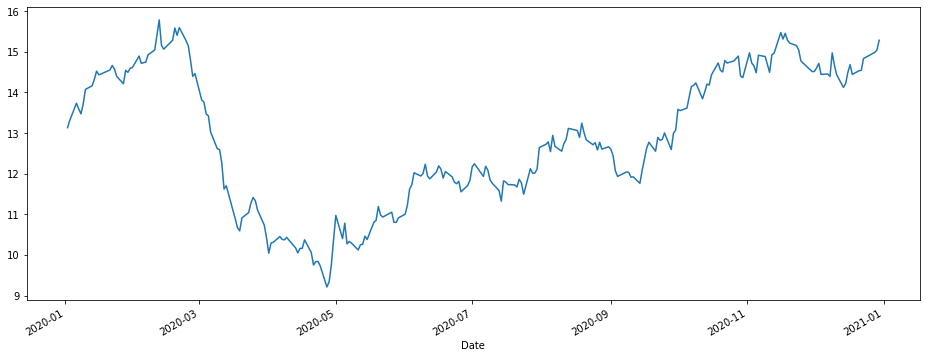

In [12]:
#visualizar serie
precio.plot(figsize=(16,6))
plt.show()

#Simulación Monte Carlo trayectorias de precio a un año
tasa de interés 6%

In [13]:
precio_ini = precio[-1]
sigma = np.std(precio)

precio_ini, sigma

(15.28, 1.6802378669700317)

In [14]:
#considerando la misma cantidad de días que en 2020 hacemos la simulación Montecarlo de un proceso Browniano
tasa = 0.06
dias = 250
n = 150000


Precios_df = simula_precios(precio_ini, tasa, sigma , dias, n  )
Precios_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250
simulacion_1,15.28,18.060977,16.406432,16.838242,16.924636,15.518943,16.016037,17.669512,21.423348,24.204305,27.569191,28.377838,28.572317,22.757259,24.761613,24.594796,25.132701,26.451455,28.883807,27.995828,26.186147,23.906331,24.018617,28.959496,31.021719,31.056018,31.889127,33.261653,37.565777,30.716065,32.915141,35.080577,30.450678,38.067732,38.962196,42.718212,40.876331,42.264086,37.170511,39.520254,...,136.734637,120.939230,124.093215,116.241834,88.711604,74.438566,68.365964,62.550513,65.729399,72.958368,80.974224,82.485213,84.880455,79.683103,80.386912,81.083577,72.062616,65.163833,59.524330,59.253655,57.803335,63.214568,58.920707,62.229396,57.902809,47.950168,50.546077,49.214918,41.152718,41.192270,36.259308,38.482675,38.178442,37.205864,38.444260,45.266676,36.448669,38.804104,39.475684,38.245700
simulacion_2,15.28,14.241048,15.525565,13.855051,12.948856,13.811845,15.031347,14.954741,12.414231,12.061508,11.908750,11.152097,13.166488,12.351759,11.195544,11.671740,10.608364,10.089715,9.829129,9.638045,9.040382,8.150291,7.433097,6.829654,6.521050,6.581173,6.071588,5.602876,5.466499,6.312361,5.559863,4.509741,4.133477,3.647805,3.657050,3.276809,3.511177,3.793990,3.611522,3.373228,...,10.391152,10.066119,10.766770,11.635520,11.912379,12.904972,13.124350,12.927537,10.446268,8.868488,8.364723,8.635698,9.553550,9.049824,9.528415,8.623158,8.989866,9.686321,8.284866,9.156307,10.148019,9.340496,8.379251,8.425654,8.962583,10.328721,10.759480,11.301402,11.371367,11.515662,12.446060,10.850052,13.451582,13.233271,14.634498,13.164291,15.062333,14.072186,12.802806,11.799585
simulacion_3,15.28,14.368106,16.113271,15.540289,13.512858,13.264096,13.793355,12.755201,13.236939,12.683623,12.029378,11.519660,12.520844,13.278299,15.014298,15.542603,16.576153,14.999121,17.902259,20.678117,24.204240,17.460202,19.067030,17.590389,19.466484,19.699734,20.188406,19.696686,22.225014,24.666996,25.968042,23.502395,18.464730,17.241330,18.109607,18.379615,19.312908,22.505071,22.636625,25.016417,...,24.843039,27.270466,24.744858,25.667068,26.420842,23.350029,21.880557,24.598039,23.176814,25.473715,22.500094,22.481951,24.170284,23.401379,26.198421,27.510835,24.156360,26.373023,28.979478,27.679610,30.658382,31.288685,27.335247,27.085756,22.729047,21.287701,20.639563,19.423589,19.433161,18.315959,18.441248,21.819707,21.363898,21.602720,25.223740,23.984206,21.223977,24.690095,25.069673,26.875795
simulacion_4,15.28,13.559896,12.339173,13.377374,12.948717,14.637623,16.254156,16.026738,16.387275,16.115447,15.055402,15.241454,14.882866,16.549065,16.575702,15.318390,16.013056,16.489452,18.190998,17.853121,16.536813,13.404067,13.506736,13.839468,13.736282,12.208089,11.126517,14.491148,16.404243,22.177777,19.167218,17.122895,16.603242,14.783650,14.146866,13.332216,16.547108,14.756701,13.675722,12.271881,...,0.326662,0.305936,0.284647,0.268824,0.265613,0.272208,0.230238,0.207557,0.231299,0.254488,0.242156,0.208352,0.213099,0.212961,0.208287,0.196101,0.181266,0.177933,0.160548,0.150334,0.149800,0.152777,0.155232,0.161605,0.155310,0.162705,0.160355,0.158361,0.165259,0.143455,0.115282,0.116890,0.117557,0.111731,0.112572,0.112189,0.125289,0.099347,0.114480,0.106068
simulacion_5,15.28,16.661541,15.717514,18.234894,14.945779,14.753333,13.651108,12.524000,14.179887,16.121673,16.131745,13.937842,12.969301,11.790294,11.735657,10.692081,9.985381,9.456270,8.794662,6.863763,6.929316,5.395245,5.167289,4.413496,4.887599,4.445634,3.550545,4.097898,4.121211,3.603886,4.259382,4.057693,3.600842,3.619600,3.114973,2.591884,2.585804,2.591320,2.540586,2.465185,...,0.736860,0.673045,0.682882,0.674120,0.697914,0.696376,0.669198,0.701242,0.648775,0.479520,0.513920,0.540570,0.560747,0.573476,0.605137,0.551544,0.568018,0.54

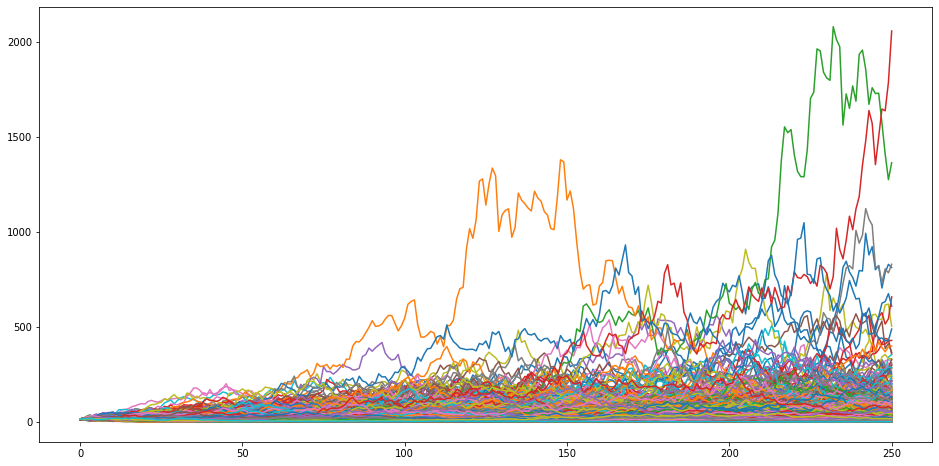

In [17]:
muestra = np.random.choice(Precios_df.index, 5000)
Precios_df.transpose()[muestra].plot(figsize=(16, 8), legend=False)
plt.show()

# Construcción de la Matriz de Ganancias

In [18]:
# Calcular Matriz de ganancias para opciones "put" 
# 0 si el precio es mayor o igual al strike
Strike = 14
Ganancia = np.maximum(Strike - Precios_df.values, np.zeros((n, dias + 1),dtype=np.float64))
pd.DataFrame(Ganancia, index = Precios_df.index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250
simulacion_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_2,0.0,0.000000,0.000000,0.144949,1.051144,0.188155,0.000000,0.000000,1.585769,1.938492,2.091250,2.847903,0.833512,1.648241,2.804456,2.328260,3.391636,3.910285,4.170871,4.361955,4.959618,5.849709,6.566903,7.170346,7.478950,7.418827,7.928412,8.397124,8.533501,7.687639,8.440137,9.490259,9.866523,10.352195,10.342950,10.723191,10.488823,10.206010,10.388478,10.626772,...,3.608848,3.933881,3.233230,2.364480,2.087621,1.095028,0.875650,1.072463,3.553732,5.131512,5.635277,5.364302,4.446450,4.950176,4.471585,5.376842,5.010134,4.313679,5.715134,4.843693,3.851981,4.659504,5.620749,5.574346,5.037417,3.671279,3.240520,2.698598,2.628633,2.484338,1.553940,3.149948,0.548418,0.766729,0.000000,0.835709,0.000000,0.000000,1.197194,2.200415
simulacion_3,0.0,0.000000,0.000000,0.000000,0.487142,0.735904,0.206645,1.244799,0.763061,1.316377,1.970622,2.480340,1.479156,0.721701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_4,0.0,0.440104,1.660827,0.622626,1.051283,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.595933,0.493264,0.160532,0.263718,1.791911,2.873483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.667784,0.000000,0.000000,0.324278,1.728119,...,13.673338,13.694064,13.715353,13.731176,13.734387,13.727792,13.769762,13.792443,13.768701,13.745512,13.757844,13.791648,13.786901,13.787039,13.791713,13.803899,13.818734,13.822067,13.839452,13.849666,13.850200,13.847223,13.844768,13.838395,13.844690,13.837295,13.839645,13.841639,13.834741,13.856545,13.884718,13.883110,13.882443,13.888269,13.887428,13.887811,13.874711,13.900653,13.885520,13.893932
simulacion_5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.348892,1.476000,0.000000,0.000000,0.000000,0.062158,1.030699,2.209706,2.264343,3.307919,4.014619,4.543730,5.205338,7.136237,7.070684,8.604755,8.832711,9.586504,9.112401,9.554366,10.449455,9.902102,9.878789,10.396114,9.740618,9.942307,10.399158,10.380400,10.885027,11.408116,11.414196,11.408680,11.459414,11.534815,...,13.263140,13.326955,13.317118,13.325880,13.302086,13.303624,13.330802,13.298758,13.351225,13.520480,13.486080,13.459430,13.439253,13.426524,13.394863,13.448456,13.431982,13.459212,13.533154,13.440193,13.268343,13.287673,13.368784,13.350019,13.389409,13.298365,13.181921,12.998818,13.079753,13.026062,13.009483,12.922806,12.922049,13.094741,13.126493,13.110731,13.19795

# Construcción de la Matriz de Valor 

In [19]:
MatrizValor = np.zeros_like(Ganancia)
MatrizValor[:, -1] = Ganancia[:, -1]  #empezamos en el ultimo día
descuento = np.exp(-tasa/dias)

#Regresión polynomial por mínimos cuadrados para calcular el valor de continuar
for t in range(dias-1, 0 , -1): #desde el penúltimo día
    x = Precios_df.iloc[:,t]
    y = MatrizValor[:, t + 1] * descuento
    #encuentra los coeficientes 
    coeficientes = np.polyfit(x, y , 2)
    valor_continuar = np.polyval(coeficientes, x)
    #Cuando la ganancia en el tiempo t sea mayor que el valor de continuar,
    MatrizValor[:, t] = np.where(Ganancia[:, t] > valor_continuar,
                                  Ganancia[:, t],
                                  MatrizValor[:, t + 1] * descuento)

pd.DataFrame(MatrizValor, index = Precios_df.index).iloc[:, -5:]

,246,247,248,249,250
simulacion_1,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_2,2.198303,2.198831,2.199359,2.199887,2.200415
simulacion_3,0.000000,0.000000,0.000000,0.000000,0.000000
simulacion_4,13.887811,13.874711,13.900653,13.885520,13.893932
simulacion_5,13.110731,13.197952,13.197734,13.173988,13.225165
...,...,...,...,...,...
simulacion_149996,8.498013,8.500053,8.502093,8.798910,8.801022
simulacion_149997,13.322355,13.423059,13.408778,13.404859,13.339420
simulacion_149998,13.696871,13.714614,13.701706,13.610925,13.543965
simulacion_149999,13.466748,13.522190,13.459213,13.510772,13.595887


In [20]:
valor_opcion_t0 = np.mean(MatrizValor[:,1]*descuento)
valor_opcion_t0

6.895748135085395

# Todo junto

In [21]:
precio_ini, Strike, sigma

(15.28, 14, 1.6802378669700317)

In [22]:
LSM(precio_ini, tasa, sigma, dias, n, Strike, 'put')

6.895748135085395

# Referencias

1. Longstaff FA, Schwartz ES. Valuing American Options by Simulation: A Simple Least-Squares Approach. Rev Financ Stud [Internet]. enero de 2001 [citado 22 de abril de 2021];14(1):113-47. Disponible en: https://academic.oup.com/rfs/article-lookup/doi/10.1093/rfs/14.1.113

2. Gustafsson W. Evaluating the Longstaff-Schwartz method for pricing of American options [Internet]. undefined. 2015 [citado 8 de febrero de 2021]. Disponible en: /paper/Evaluating-the-Longstaff-Schwartz-method-for-of-Gustafsson/d1e22230c3852f60bef3b32f4230fefc88a18768

3. tirthajyoti/Stats-Maths-with-Python [Internet]. GitHub. [citado 9 de febrero de 2021]. Disponible en: https://github.com/tirthajyoti/Stats-Maths-with-Python

